In [229]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [230]:
# Load the training and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Preprocess the data (e.g., handle missing values, scale the features, etc.)
# Split the data into input features and target variable (stock prices)
train_features= train_data['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%m-%d-%Y'))
test_features= test_data['date'].apply(lambda x: datetime.strptime(x, '%m-%d-%Y').strftime('%m-%d-%Y'))
train_target = train_data['price']

# Concatenate the training and test sets
combined_df = pd.concat([train_features, test_features], axis=0)

# Perform ordinal encoding on the date feature
combined_encoded, _ = pd.factorize(combined_df)

# Split the combined encoded data back into training and test sets
encoded_train_features = combined_encoded[:(len(train_features))]
encoded_test_features = combined_encoded[(len(train_features)):]

display(pd.DataFrame(encoded_train_features))

,0
0,0
1,1
2,2
3,3
4,4
...,...
1002,1002
1003,1003
1004,1004
1005,1005


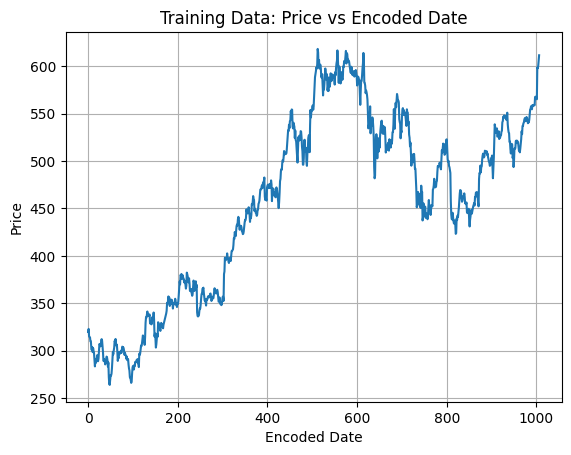

In [231]:
# Get the original dates and prices
original_dates = train_features
prices = train_target[start_index:]

# Plot the prices against the encoded dates
plt.plot(encoded_train_features, prices)
plt.xlabel('Encoded Date')
plt.ylabel('Price')
plt.title('Training Data: Price vs Encoded Date')
plt.grid(True)
plt.show()

In [232]:
batch_size = 32

# Convert the data into PyTorch tensors
encoded_train_features = torch.Tensor(encoded_train_features)
train_target = torch.Tensor(train_target)
encoded_test_features = torch.Tensor(encoded_test_features)

class MyDataset(Dataset):
    def __init__(self, features, targets=None):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        if self.targets is not None:
            target = self.targets[index]
            return feature, target
        else:
            return feature

# Convert the training data into PyTorch DataLoader
trainset = MyDataset(encoded_train_features, train_target)  # Create a custom Dataset if needed
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Convert the testing data into PyTorch DataLoader
testset = MyDataset(encoded_test_features)  # Create a custom Dataset if needed
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# display(pd.DataFrame(encoded_train_features))
print(encoded_test_features.size())

torch.Size([252])


In [233]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x.unsqueeze(2), h0)
        out = self.fc(out[:, -1, :])
        return out

# Set the hyperparameters
input_size = 1  # Number of input features
hidden_size = 48  # Number of hidden units in the RNN
output_size = 1  # Number of output units
num_layers = 2

# Create an instance of the RNN model
model = SimpleRNN(input_size, hidden_size, output_size,num_layers)

# Set the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_features, batch_targets in trainloader:
        optimizer.zero_grad()

        # Reshape the input data to have the shape (batch_size, sequence_length, input_size)
        batch_features = batch_features.unsqueeze(1)

        # Forward pass
        outputs = model(batch_features)
        loss = torch.sqrt(criterion(outputs, batch_targets.unsqueeze(1)))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

# Make predictions on the test set
predictions = []
model.eval()
with torch.no_grad():
    for batch_features in testloader:
        # Reshape the input data to have the shape (batch_size, sequence_length, input_size)
        batch_features = batch_features.unsqueeze(1)

        outputs = model(batch_features)
        predictions.extend(outputs.squeeze().tolist())

# Convert the predictions back to a pandas DataFrame
predictions_df = pd.DataFrame(predictions, columns=['price'])
print(predictions_df)




Streaming output truncated to the last 5000 lines.
Epoch [15/5000], Loss: 450.203332901001
Epoch [16/5000], Loss: 449.3662576675415
Epoch [17/5000], Loss: 448.24116134643555
Epoch [18/5000], Loss: 447.98576068878174
Epoch [19/5000], Loss: 447.14956188201904
Epoch [20/5000], Loss: 446.22484397888184
Epoch [21/5000], Loss: 444.67004680633545
Epoch [22/5000], Loss: 444.5178966522217
Epoch [23/5000], Loss: 444.7454605102539
Epoch [24/5000], Loss: 443.23316764831543
Epoch [25/5000], Loss: 442.0990114212036
Epoch [26/5000], Loss: 442.1611862182617
Epoch [27/5000], Loss: 441.15588569641113
Epoch [28/5000], Loss: 440.01073837280273
Epoch [29/5000], Loss: 439.5614900588989
Epoch [30/5000], Loss: 438.92172145843506
Epoch [31/5000], Loss: 437.84852027893066
Epoch [32/5000], Loss: 436.42223739624023
Epoch [33/5000], Loss: 435.1059761047363
Epoch [34/5000], Loss: 435.47751331329346
Epoch [35/5000], Loss: 434.9507761001587
Epoch [36/5000], Loss: 433.778639793396
Epoch [37/5000], Loss: 433.5114316940

In [234]:
# Convert predictions DataFrame to a Series
predictions_series = predictions_df['price']

# Create a new DataFrame for results
results = test_data.copy()

# Add predictions column to results DataFrame
results['price'] = predictions_series
# Save the predictions DataFrame to a CSV file
results.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv.")
display(results.head())



Predictions saved to predictions.csv.


,date,price
0,11-15-2015,547.534668
1,11-16-2015,547.769836
2,11-17-2015,548.001953
3,11-18-2015,548.231079
4,11-19-2015,548.457214


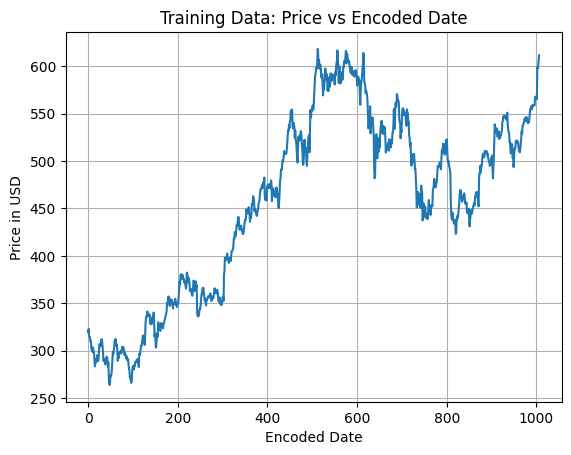

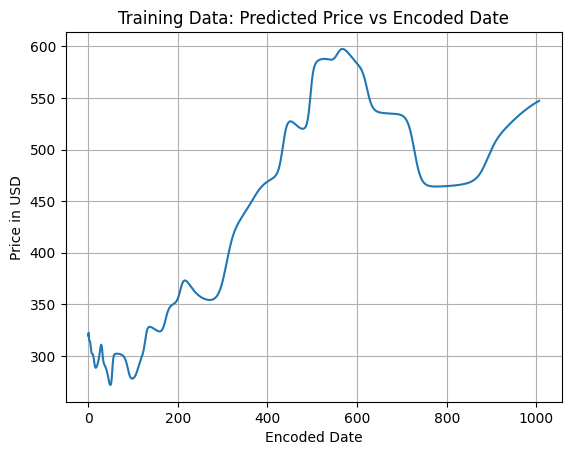

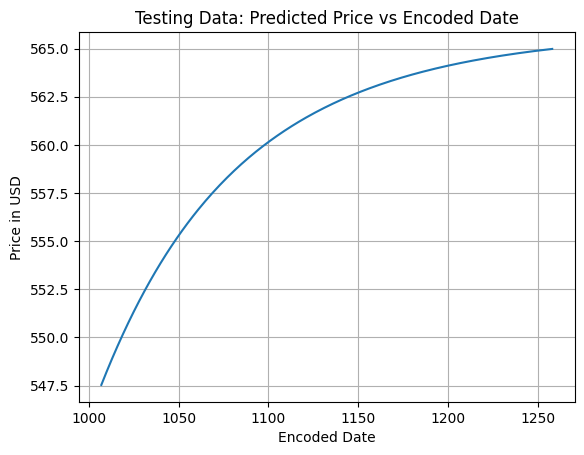

In [235]:
# Get the original dates and prices
original_dates = train_features

# Plot the prices against the encoded dates
plt.plot(encoded_train_features, train_target)
plt.xlabel('Encoded Date')
plt.ylabel('Price in USD')
plt.title('Training Data: Price vs Encoded Date')
plt.grid(True)
plt.show()

# Generate predictions for the training data
with torch.no_grad():
    model.eval()
    predictions = model(encoded_train_features.unsqueeze(1).float()).squeeze().numpy()

# Plot the predictions
plt.plot(encoded_train_features, predictions, label='Predictions')

plt.xlabel('Encoded Date')
plt.ylabel('Price in USD')
plt.title('Training Data: Predicted Price vs Encoded Date')
plt.grid(True)
plt.show()

# Generate predictions for the testing data
with torch.no_grad():
    model.eval()
    predictions = model(encoded_test_features.unsqueeze(1).float()).squeeze().numpy()

# Plot the predictions
plt.plot(encoded_test_features, predictions, label='Predictions')

plt.xlabel('Encoded Date')
plt.ylabel('Price in USD')
plt.title('Testing Data: Predicted Price vs Encoded Date')
plt.grid(True)
plt.show()
